# Style Transfer with Convolutional Neural Networks

In [163]:
import torchvision.models as models
import torch
import numpy as np
import torch.nn as nn
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
%matplotlib inline

In [164]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

# Loss functions

In [165]:
vgg = models.vgg16(pretrained=True)
mse = nn.MSELoss()

## Content Loss

### Content Image

torch.Size([3, 224, 224])


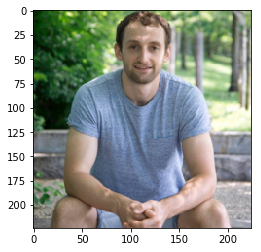

In [166]:
content_image = U.get_image(3, None)
print(content_image.size())
U.imshow(content_image)

In [176]:

#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
selected_convolutional_indexes = [2, 14]
module_lists = [list(vgg.features.children())[:index+1] for index in  selected_convolutional_indexes]
content_models = [ U.convert_to_average_pooling(modules) for modules in module_lists ]

def content_loss(model, generated_image, content_image, weight):
    prediction = Variable(generated_image, requires_grad = True)
    pred = model.forward(prediction.unsqueeze(0))

    freeze_model(model)
    target = model.forward(content_image.unsqueeze(0))
        
    loss_amt = mse(pred, target) * weight
    loss_amt.backward()
    content_gradients = prediction.grad.data.numpy().flatten().astype(np.float64)
    model.zero_grad()
    
    c_loss = loss_amt.data.numpy().astype(np.float64)

    return c_loss, content_gradients

def content_loss_and_gradients(gen_img, content_image, weight):
    loss_and_gradients = [ content_loss(model, gen_img, content_image, weight) for model in content_models ]
    total_content_loss = sum([ loss for loss, grads in  loss_and_gradients])
    total_content_gradients = sum([ grads for loss, grads in  loss_and_gradients])

    return total_content_loss, total_content_gradients

## Style Loss

### Style Image

torch.Size([3, 224, 224])


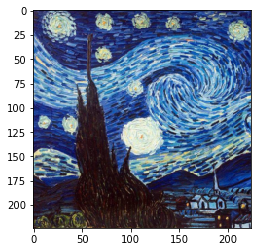

In [177]:
style_image = U.get_image(5, None, 112)
print(style_image.size())
U.imshow(style_image)

In [178]:
#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
selected_convolutional_indexes = [2, 7, 12, 17, 21]
module_lists = [list(vgg.features.children())[:index+1] for index in  selected_convolutional_indexes]
conv_layer_models = [ U.convert_to_average_pooling(modules) for modules in module_lists ]

In [241]:
def gram_matrix(x):
    batch_size = x.size()[0]
    height  = x.size()[1]
    width = x.size()[2]
    chan = x.size()[3]
    flattened_channels = x.resize(batch_size, chan, width * height)
    g_matrix = flattened_channels[0].matmul(flattened_channels[0].transpose(1,0)).unsqueeze(0) 
    return g_matrix

def style_loss(model, generated_image_layer, style_image_layer, weight):
    prediction = Variable(generated_image_layer, requires_grad = True)
    
    pred = model.forward(prediction.unsqueeze(0))
    
    freeze_model(model)
    target = model.forward(style_image_layer.unsqueeze(0))
    
    loss_amt = mse(gram_matrix(pred), gram_matrix(target)) * weight
    loss_amt.backward()
    
    style_gradients = prediction.grad.data.numpy().flatten().astype(np.float64)
    s_loss = loss_amt.data.numpy().astype(np.float64)
    model.zero_grad()

    return s_loss, style_gradients
import pdb

model_weights = [0.1,0.3,0.3,0.35,0.4]
def style_loss_and_gradients(gen_image, style_image):
    style_image = Variable(style_image, requires_grad = False)
    losses_and_gradients = [style_loss(model, gen_image, style_image, weight) for model, weight in zip(conv_layer_models, model_weights) ]
    total_style_loss = sum([ loss for loss, grads in losses_and_gradients ])
    total_style_gradients = sum([grads for loss, grads in losses_and_gradients])
    return total_style_loss, total_style_gradients

# Minimize noise based on vgg output

In [242]:
from scipy.optimize import fmin_l_bfgs_b 

In [243]:
class StyleTransfer():
    def __init__(self, style_image, content_image):
        self.style_image = style_image
        self.content_image = content_image
        self.count = 0 
        self.gradient_mag_diff = 10
                
    def loss_fn(self, flattened_image):
        self.count += 1
        predicted_image = torch.Tensor(flattened_image.reshape(content_image.size()))
        c_loss, content_gradients = content_loss_and_gradients(predicted_image, self.content_image, self.gradient_mag_diff)
        s_loss, style_gradients = style_loss_and_gradients(predicted_image, self.style_image)
        threshold = 1000
        if s_loss > c_loss:
            divisiable = int(s_loss / c_loss) / threshold
            if divisiable > 10:
                new_diff = self.gradient_mag_diff * (10**len(str(divisiable)))
        else:
            divisiable = int(s_loss / c_loss) / threshold
            if divisiable > 10:
                new_diff = self.gradient_mag_diff * (10** (-1 *len(str(divisiable))))

        print("s_loss ", int(s_loss))
        print("c_loss ", int(c_loss))
        print("Content weights", self.gradient_mag_diff)
        if divisiable > 10:
            print("Updating Content scale from: "+str(len(str(self.gradient_mag_diff))) +" to: " +str(len(str(new_diff))))
            self.gradient_mag_diff = new_diff            
        return s_loss + c_loss,  style_gradients + content_gradients

In [244]:
noise_tensor = torch.rand(3,224, 224) - 0.5
import pdb
def transfer_style(transfer_class, maxfun, iters, starting_image):
    gen_image = starting_image.numpy().flatten()
    for i in range(iters):
        generated_image, min_val, y = fmin_l_bfgs_b(transfer_class.loss_fn, gen_image, maxfun=maxfun)
        print("Epoch "+str(i) + " Loss: " +str(min_val))
        gen_image = generated_image
    return gen_image

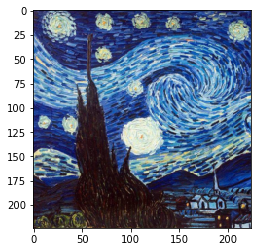

In [224]:
U.imshow(style_image)

In [225]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 1, noise_tensor)

('s_loss ', 1929128704)
('c_loss ', 324)
('Content weights', 10)
Updating Content scale from: 2 to: 9
('s_loss ', 1891391796)
('c_loss ', 3251361408)
('Content weights', 100000000)
('s_loss ', 1929037640)
('c_loss ', 3244076480)
('Content weights', 100000000)
('s_loss ', 1929128704)
('c_loss ', 3244054208)
('Content weights', 100000000)
('s_loss ', 1929128704)
('c_loss ', 3244054208)
('Content weights', 100000000)
('s_loss ', 1929128704)
('c_loss ', 3244054208)
('Content weights', 100000000)
Epoch 0 Loss: [  5.17318291e+09]


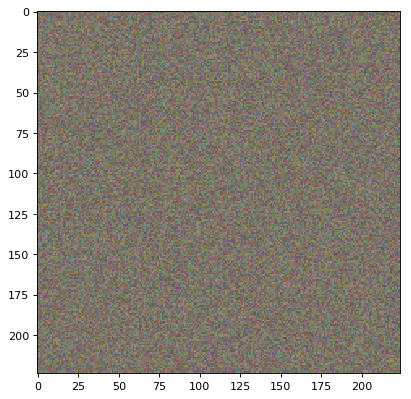

In [226]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [227]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 2, torch.Tensor(result))

('s_loss ', 1929128704)
('c_loss ', 324)
('Content weights', 10)
Updating Content scale from: 2 to: 9
('s_loss ', 1891391796)
('c_loss ', 3251361408)
('Content weights', 100000000)
('s_loss ', 1929037640)
('c_loss ', 3244076480)
('Content weights', 100000000)
('s_loss ', 1929128704)
('c_loss ', 3244054208)
('Content weights', 100000000)
('s_loss ', 1929128704)
('c_loss ', 3244054208)
('Content weights', 100000000)
('s_loss ', 1929128704)
('c_loss ', 3244054208)
('Content weights', 100000000)
Epoch 0 Loss: [  5.17318291e+09]
('s_loss ', 1929128704)
('c_loss ', 3244054208)
('Content weights', 100000000)
('s_loss ', 1907701222)
('c_loss ', 3203936384)
('Content weights', 100000000)
('s_loss ', 1856444520)
('c_loss ', 3063167936)
('Content weights', 100000000)
('s_loss ', 1554670283)
('c_loss ', 2641634048)
('Content weights', 100000000)
('s_loss ', 867729536)
('c_loss ', 2518216064)
('Content weights', 100000000)
('s_loss ', 605821224)
('c_loss ', 2297841280)
('Content weights', 100000000

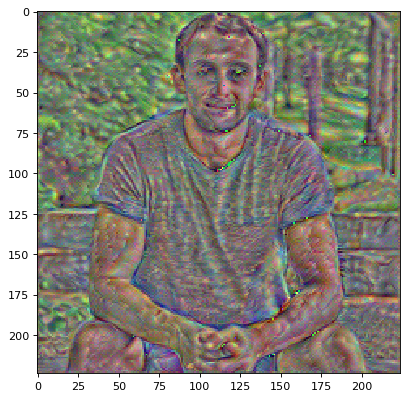

In [228]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [159]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 2, torch.Tensor(result))

('s_loss ', array([ 53179715.25]))
('c_loss ', array([  1.32132344e+08]))
('s_loss ', array([ 47997844.75]))
('c_loss ', array([  1.22719508e+08]))
('s_loss ', array([ 42687966.875]))
('c_loss ', array([  1.15172892e+08]))
('s_loss ', array([ 36107901.375]))
('c_loss ', array([  1.10415328e+08]))
Epoch 0 Loss: [  1.45128715e+08]
('s_loss ', array([ 36218397.125]))
('c_loss ', array([  1.05518912e+08]))
('s_loss ', array([ 35358268.25]))
('c_loss ', array([  1.02617420e+08]))
('s_loss ', array([ 32848382.375]))
('c_loss ', array([ 99746260.]))
('s_loss ', array([ 32241006.25]))
('c_loss ', array([ 96078968.]))
Epoch 1 Loss: [  1.26085574e+08]


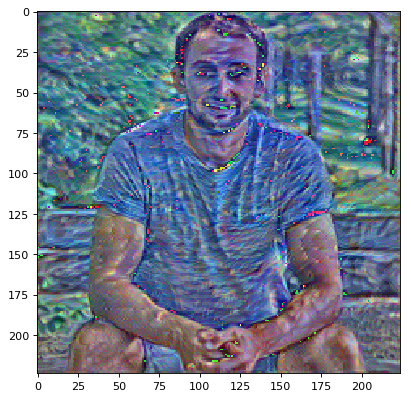

In [160]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [239]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 2, torch.Tensor(result))

('s_loss ', 216052061)
('c_loss ', 38)
('Content weights', 10)
Updating Content scale from: 2 to: 6
('s_loss ', 208559831)
('c_loss ', 390263)
('Content weights', 100000)
('s_loss ', 204683606)
('c_loss ', 397501)
('Content weights', 100000)
('s_loss ', 179951453)
('c_loss ', 472183)
('Content weights', 100000)
('s_loss ', 144531699)
('c_loss ', 715920)
('Content weights', 100000)
('s_loss ', 134101624)
('c_loss ', 796566)
('Content weights', 100000)
('s_loss ', 125882426)
('c_loss ', 908839)
('Content weights', 100000)
('s_loss ', 120106299)
('c_loss ', 1073037)
('Content weights', 100000)
('s_loss ', 110898406)
('c_loss ', 1087027)
('Content weights', 100000)
('s_loss ', 105036728)
('c_loss ', 1095872)
('Content weights', 100000)
('s_loss ', 98693605)
('c_loss ', 1139285)
('Content weights', 100000)
('s_loss ', 90369578)
('c_loss ', 1367146)
('Content weights', 100000)
('s_loss ', 82301123)
('c_loss ', 1340717)
('Content weights', 100000)
('s_loss ', 80590179)
('c_loss ', 1325089)
('

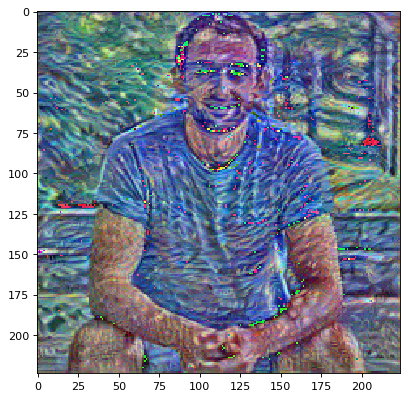

In [240]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [245]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 2, torch.Tensor(result))

('s_loss ', 32985811)
('c_loss ', 202)
('Content weights', 10)
Updating Content scale from: 2 to: 5
('s_loss ', 32957481)
('c_loss ', 202917)
('Content weights', 10000)
('s_loss ', 32673602)
('c_loss ', 202675)
('Content weights', 10000)
('s_loss ', 32308554)
('c_loss ', 202959)
('Content weights', 10000)
('s_loss ', 30634612)
('c_loss ', 204653)
('Content weights', 10000)
('s_loss ', 29008997)
('c_loss ', 205871)
('Content weights', 10000)
('s_loss ', 27103304)
('c_loss ', 207204)
('Content weights', 10000)
('s_loss ', 25843521)
('c_loss ', 208327)
('Content weights', 10000)
('s_loss ', 24953803)
('c_loss ', 208976)
('Content weights', 10000)
('s_loss ', 24222651)
('c_loss ', 209315)
('Content weights', 10000)
('s_loss ', 22617372)
('c_loss ', 210683)
('Content weights', 10000)
('s_loss ', 19973178)
('c_loss ', 216599)
('Content weights', 10000)
('s_loss ', 20459481)
('c_loss ', 218138)
('Content weights', 10000)
('s_loss ', 18889717)
('c_loss ', 217229)
('Content weights', 10000)
('s

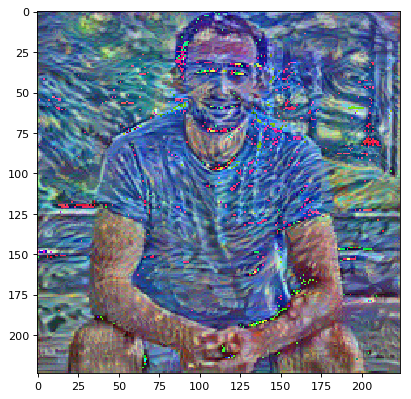

In [246]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [247]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 2, torch.Tensor(result))

('s_loss ', 10744676)
('c_loss ', 228)
('Content weights', 10)
Updating Content scale from: 2 to: 4
('s_loss ', 12341947)
('c_loss ', 22887)
('Content weights', 1000)
('s_loss ', 10628223)
('c_loss ', 22888)
('Content weights', 1000)
('s_loss ', 10596347)
('c_loss ', 22885)
('Content weights', 1000)
('s_loss ', 10536144)
('c_loss ', 22891)
('Content weights', 1000)
('s_loss ', 10489403)
('c_loss ', 22908)
('Content weights', 1000)
('s_loss ', 10406129)
('c_loss ', 22944)
('Content weights', 1000)
('s_loss ', 10278076)
('c_loss ', 22991)
('Content weights', 1000)
('s_loss ', 10149353)
('c_loss ', 23083)
('Content weights', 1000)
('s_loss ', 9999529)
('c_loss ', 23104)
('Content weights', 1000)
('s_loss ', 9872152)
('c_loss ', 23105)
('Content weights', 1000)
('s_loss ', 9645379)
('c_loss ', 23153)
('Content weights', 1000)
('s_loss ', 9382696)
('c_loss ', 23279)
('Content weights', 1000)
('s_loss ', 9460305)
('c_loss ', 23476)
('Content weights', 1000)
('s_loss ', 9250097)
('c_loss ', 2

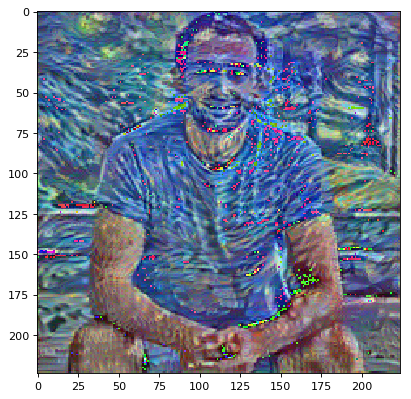

In [248]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))